In [1]:
import os
import random
import sys

SRC_PATH = os.path.abspath(os.path.join("../.."))
sys.path.append(SRC_PATH)

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
print("numpy", np.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print(f"Training on {DEVICE}")


numpy 1.20.3
torch 1.11.0
torchvision 0.12.0
Training on cuda


In [3]:
def load_data(src_path: str = "."):
    """Load CIFAR-100 (training and test set)."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    transform_test = transforms.Compose([transforms.ToTensor()])
    trainset = CIFAR100(
        os.path.join(os.path.abspath(src_path), "data", "cifar100"),
        train=True,
        download=True,
        transform=transform_train,
    )
    testset = CIFAR100(
        os.path.join(os.path.abspath(src_path), "data", "cifar100"),
        train=False,
        download=True,
        transform=transform_test,
    )
    return trainset, testset

In [4]:
# Load data
BATCH_SIZE = 128
trainset, testset = load_data("../..")
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


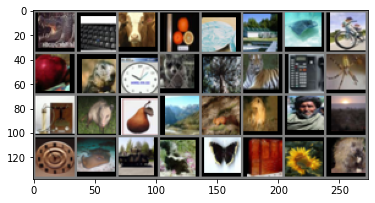

crocodile - keyboard - cattle - orange - plate - house -   ray - bicycle - 
apple - beaver - clock - raccoon - pine_tree - tiger - telephone - spider - 
telephone - possum -  pear - mountain - squirrel -  lion -   man - plain - 
clock -   ray -  tank - skunk - butterfly - wardrobe - sunflower - porcupine - 



In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images[:32]))
print(''.join('%5s - ' % trainset.classes[labels[j]].replace(" ", "") + ("\n" if (j + 1) % 8 == 0 else "") for j in range(32)))

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def SepConv2d(in_channels, out_channels):
    depth_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False)
    point_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
    return nn.Sequential(depth_conv, point_conv)

In [32]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = SepConv2d(16, 32)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = SepConv2d(32, 32)
        self.bn3 = nn.BatchNorm2d(32)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv4 = SepConv2d(32, 64)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = SepConv2d(64, 64)
        self.bn5 = nn.BatchNorm2d(64)

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv6 = SepConv2d(64, 128)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = SepConv2d(128, 128)
        self.bn7 = nn.BatchNorm2d(128)

        self.fc = nn.Linear(128, 100)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(self.bn5(self.conv5(x)))
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.bn7(self.conv7(x))
        
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [94]:
# Load model
model = Net().to(DEVICE)
print("Number of parameters:", count_parameters(model))

Number of parameters: 49540


In [95]:
EPOCHS = 160
MILESTONES = [80, 120]
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)  # learning rate decay

In [96]:
def train(model, trainloader, criterion, optimizer, device):
    """Train the network on the training set."""
    model.train()
    correct, total, epoch_loss = 0, 0, 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * labels.size(0)
        total += labels.size(0)
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    epoch_loss /= total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc 

In [97]:
def test(model, testloader, criterion, device):
    """Validate the network on the entire test set."""
    model.eval()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item() * targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    loss /= total
    accuracy = correct / total
    return loss, accuracy

In [98]:
# Check initial evaluation metrics
loss, accuracy = test(model, testloader, criterion, DEVICE)
print(f"Initial test set performance: loss {loss}, accuracy {accuracy}")

Initial test set performance: loss 4.6067770568847655, accuracy 0.0113


In [99]:
# Start centralized training
hist = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
    test_loss, test_accuracy = test(model, testloader, criterion, DEVICE)
    train_scheduler.step()
    hist["train_loss"].append(train_loss)
    hist["train_accuracy"].append(train_accuracy)
    hist["test_loss"].append(test_loss)
    hist["test_accuracy"].append(test_accuracy)
    print(f"##########       EPOCH - {epoch}       ##########")
    print(f"Train set performance: loss {train_loss}, accuracy {train_accuracy}")
    print(f"Test set performance: loss {test_loss}, accuracy {test_accuracy}")

{'train_loss': [3.7065094245910646], 'train_accuracy': [0.12754], 'test_loss': [6.08284818649292], 'test_accuracy': [0.0442]}, learning rate 0.1
{'train_loss': [3.7065094245910646, 3.1795501907348633], 'train_accuracy': [0.12754, 0.2159], 'test_loss': [6.08284818649292, 4.727768437957764], 'test_accuracy': [0.0442, 0.0585]}, learning rate 0.1
{'train_loss': [3.7065094245910646, 3.1795501907348633, 2.9190071836853027], 'train_accuracy': [0.12754, 0.2159, 0.26474], 'test_loss': [6.08284818649292, 4.727768437957764, 4.398438488769531], 'test_accuracy': [0.0442, 0.0585, 0.1018]}, learning rate 0.1


KeyboardInterrupt: 